In [1444]:
#Standard Packages:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import MonthEnd
import matplotlib.pyplot as plt
import time
import seaborn as sns


#Statsmodels:
import statsmodels.api as sma
import statsmodels as sm
from statsmodels import tsa
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import t, probplot

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
pd.options.mode.chained_assignment = None  # default='warn'
from sklearn.linear_model import LinearRegression
from pmdarima.arima.utils import ndiffs
from statsmodels.graphics.tsaplots import plot_acf

In [1445]:
def difference(series, order=1):
    """
    Apply differencing to a time series.
    If order > 1, difference repeatedly order times.
    """
    diffed = series.copy()
    for _ in range(order):
        diffed = diffed.diff().dropna()
    return diffed

def invert_difference(last_original, differenced):
    """
    Invert a single differencing step.
    last_original is the last known observation before differencing.
    differenced is the differenced value to be inverted.
    """
    return last_original + differenced

def create_lag_features(series, p, q):
    """
    Create AR and MA features.
    AR features: lagged values of series
    MA features: lagged residuals (will be filled after fitting)
    For training, residuals are initially unknown, so we will do iterative fitting.
    """
    # AR lags
    X_ar = pd.concat([series.shift(i) for i in range(1, p+1)], axis=1)
    X_ar.columns = [f'lag_{i}' for i in range(1, p+1)]
    
    # MA lags - initially zero or NaN, will be updated after we get residuals
    X_ma = pd.DataFrame(index=series.index)
    if q > 0:
        for j in range(1, q+1):
            X_ma[f'ma_{j}'] = 0  # placeholder

    # Combine
    if q > 0:
        X = pd.concat([X_ar, X_ma], axis=1)
    else:
        X = X_ar
    
    # Drop rows with NaN due to lagging
    X = X.dropna()
    y = series.loc[X.index]
    return X, y

def ARIMA(p, i, q, df):
    """
    Fit an ARIMA(p, i, q) model to the given time series `df`.
    df: Pandas Series of the time series values.
    
    Returns:
    model_dict: A dictionary containing the fitted model information.
    """
    # Ensure df is a series
    if not isinstance(df, pd.Series):
        df = pd.Series(df)
        
    original_series = df.copy()
    
    # Difference the series i times
    differenced_series = difference(df, order=i)
    
    # Create initial AR and placeholder MA features
    X, y = create_lag_features(differenced_series, p, q)
    
    # Initialize model
    model = LinearRegression()
    
    # We have a two-step fitting process:
    # Step 1: Fit AR part ignoring MA (since we don't have residuals yet).
    # Step 2: Estimate residuals, then refit with MA terms filled in.
    
    if q == 0:
        # If no MA terms, just fit once
        model.fit(X, y)
        residuals = y - model.predict(X)
    else:
        # Step 1: Fit AR-only model
        # Use only AR columns
        ar_cols = [col for col in X.columns if col.startswith('lag_')]
        model.fit(X[ar_cols], y)
        residuals = y - model.predict(X[ar_cols])
        
        # Now fill in the MA features with lagged residuals
        for j in range(1, q+1):
            X[f'ma_{j}'] = residuals.shift(j)
        
        # Drop rows with NaN after adding residuals
        combined = pd.concat([X, y], axis=1).dropna()
        X = combined[X.columns]
        y = combined[y.name]
        
        # Refit with AR+MA
        model.fit(X, y)
        residuals = y - model.predict(X)
        
    # Store model parameters
    # Coefficients are in order: AR lags first, then MA lags
    coef = model.coef_
    intercept = model.intercept_
    
    # Save model components
    model_dict = {
        'p': p,
        'i': i,
        'q': q,
        'model': model,
        'intercept': intercept,
        'coef': coef,
        'X_cols': X.columns,
        'original_series': original_series,
        'differenced_series': differenced_series,
        'residuals': residuals,
        'last_values': original_series.iloc[-p:].values,  # last p original values for future predictions
        'last_diff_values': differenced_series.iloc[-max(p, q):].values if len(differenced_series) > max(p, q) else differenced_series.values,
    }
    return model_dict

In [1446]:
def forecast(model_dict, steps=1):
    """
    Forecast future values based on the fitted ARIMA model.
    This function produces forecasts one-step ahead, iteratively.
    """
    p = model_dict['p']
    i = model_dict['i']
    q = model_dict['q']
    model = model_dict['model']
    X_cols = model_dict['X_cols']
    original_series = model_dict['original_series']
    residuals = model_dict['residuals']
    
    # Current "history" for differenced series is what's in model_dict
    differenced_series = model_dict['differenced_series']
    
    # We will forecast differenced values and then invert differencing
    forecasts = []
    
    # We need to keep track of recent lags of differenced series and residuals
    current_diff = differenced_series.copy()
    current_resid = residuals.copy()
    
    for _ in range(steps):
        # Build the feature vector for the next time step
        ar_features = []
        for lag in range(1, p+1):
            if len(current_diff) - lag >= 0:
                ar_features.append(current_diff.iloc[-lag])
            else:
                ar_features.append(np.nan)
        
        ma_features = []
        for lag in range(1, q+1):
            if len(current_resid) - lag >= 0:
                ma_features.append(current_resid.iloc[-lag])
            else:
                ma_features.append(0.0)
        
        # Create a single-row dataframe for prediction
        row_data = ar_features + ma_features
        X_pred = pd.DataFrame([row_data], columns=X_cols)
        
        # Predict the differenced value
        diff_forecast = model.predict(X_pred)[0]
        
        # Update current differenced series
        new_index = current_diff.index[-1] + 1 if isinstance(current_diff.index[-1], (int, float)) else current_diff.index[-1] + pd.Timedelta('1D')
        current_diff = pd.concat([current_diff, pd.Series([diff_forecast], index=[new_index])])
        
        # For forecasting future steps, we assume zero residual (since unknown future error)
        current_resid = pd.concat([current_resid, pd.Series([0.0], index=[new_index])])
        
        # Invert differencing
        if i > 1:
            raise NotImplementedError("Multiple differencing inversion not implemented.")
        
        last_original_value = original_series.iloc[-1] if len(forecasts) == 0 else forecasts[-1]
        inv_forecast = last_original_value + diff_forecast
        forecasts.append(inv_forecast)
    
    return forecasts


In [1447]:
def get_significant_acf_lags(series, max_lag=40, alpha=0.05):
    # Drop missing values
    data = series.dropna()
    
    # Calculate ACF and confidence intervals
    acf_vals, confint = acf(data, nlags=max_lag, alpha=alpha)
    
    # Identify significant lags
    significant_lags = []
    for lag in range(1, len(acf_vals)):  # start from lag=1 since lag=0 is always 1
        lower, upper = confint[lag]
        # If CI does not include zero
        if lower > 0 or upper < 0:
            significant_lags.append(lag)
            
    return significant_lags

def get_significant_pacf_lags(series, max_lag=40, alpha=0.05):
    # Drop missing values
    data = series.dropna()
    
    # Calculate ACF and confidence intervals
    pacf_vals, confint = pacf(data, nlags=max_lag, alpha=alpha)
    
    # Identify significant lags
    significant_lags = []
    for lag in range(1, len(pacf_vals)):  # start from lag=1 since lag=0 is always 1
        lower, upper = confint[lag]
        # If CI does not include zero
        if lower > 0 or upper < 0:
            significant_lags.append(lag)
            
    return significant_lags

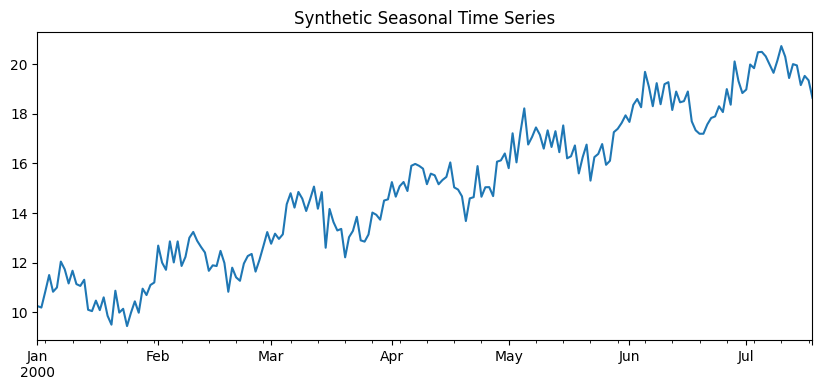

In [1448]:
# Set a seed for reproducibility
np.random.seed(42)

# Create a time index
n_points = 200
time_index = pd.date_range(start='2000-01-01', periods=n_points, freq='D')

# Generate a seasonal pattern (sine wave)
seasonality_period = 30
offset = 10
seasonal_pattern = np.sin(2 * np.pi * np.arange(n_points) / seasonality_period)

# Add some trend (e.g., linear upward trend)
trend = 0.05 * np.arange(n_points)

# Add random noise
noise = np.random.normal(loc=0.0, scale=0.5, size=n_points)

# Combine these components
data = offset + trend + seasonal_pattern + noise

# Create a Pandas Series
df = pd.Series(data, index=time_index, name='value')

# Plot the series
df.plot(title='Synthetic Seasonal Time Series', figsize=(10, 4))
plt.show()

#print(df.head())

In [1449]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(df)

# Print the result of the ADF test
#print("ADF Statistic:", adf_result[0])
#print("p-value:", adf_result[1])
#print("Used Lag:", adf_result[2])
#print("Number of Observations Used:", adf_result[3])
#print("Critical Values:", adf_result[4])
print("Conclusion: The series is stationary" if adf_result[1] < 0.05 else "Conclusion: The series is non-stationary")

Conclusion: The series is non-stationary


In [1450]:
# Find the number of differences (d) needed to make the series stationary
ndiffs_value = ndiffs(df)

# Print the result
print(f"Optimal number of differences (d): {ndiffs_value}")

Optimal number of differences (d): 1


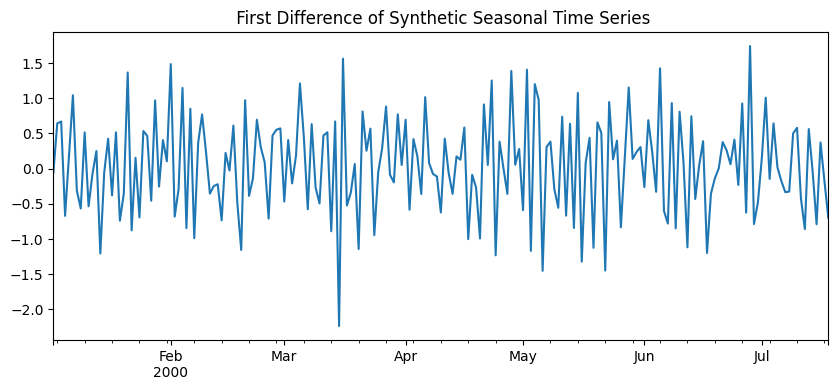

In [1451]:
df_diffed = difference(df)

df_diffed.plot(title=' First Difference of Synthetic Seasonal Time Series', figsize=(10, 4))
plt.show()

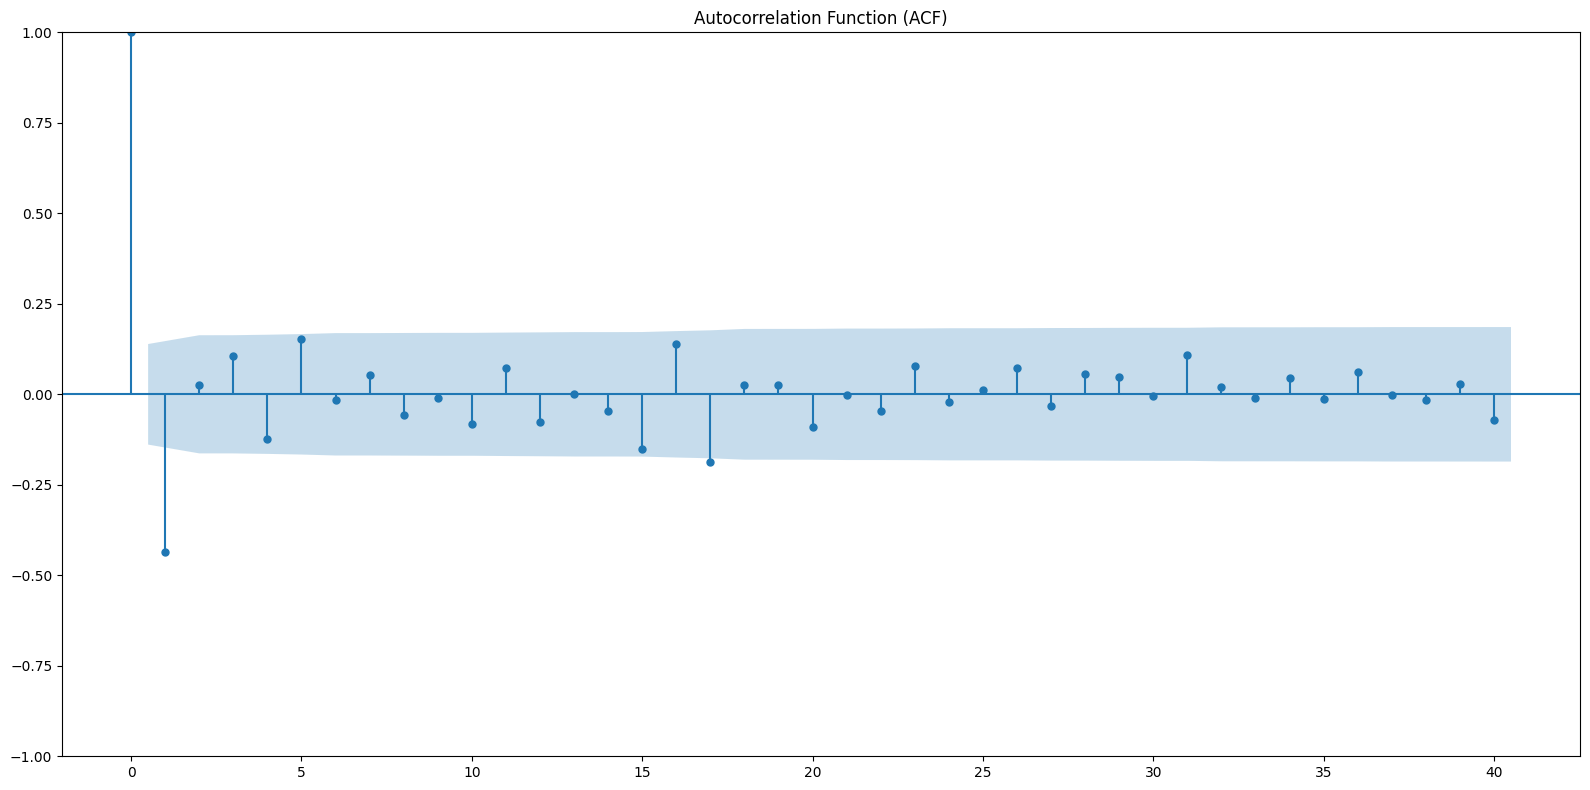

Significant ACF lags:
[1, 17]


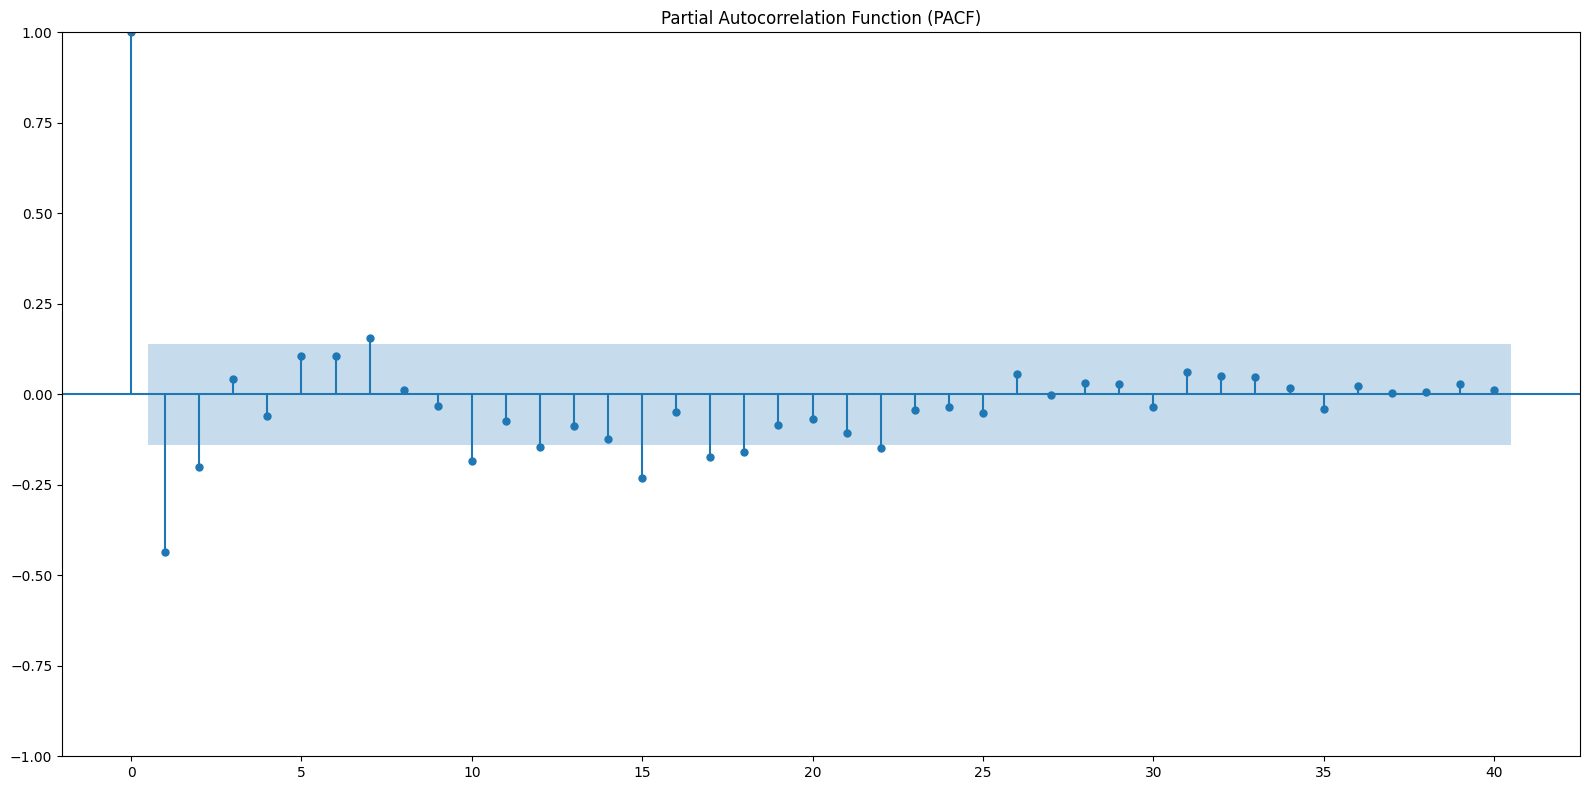

Significant PACF lags:
[1, 2, 7, 10, 12, 15, 17, 18, 21, 22, 25]


In [1452]:
# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_acf(df_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Autocorrelation Function (ACF)')
plt.tight_layout()
plt.show()
ax.set_title('Autocorrelation Function (ACF) of the First Difference')

# Print the significant lags
q = get_significant_acf_lags(df_diffed)
print("Significant ACF lags:")
print(q)

# Create a figure with 2 subplots (one for the price and one for the ACF)
#fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig, ax = plt.subplots(figsize=(16, 8))
# Plot the ACF for the 'PRC' column (on the second subplot)
plot_pacf(df_diffed.dropna(), lags=40, ax=ax)
ax.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()
ax.set_title('Partial Autocorrelation Function (PACF) of the First Difference')

# Print the significant lags
p = get_significant_pacf_lags(df_diffed)

print("Significant PACF lags:")
print(p)

2000-07-19    19.128324
2000-07-20    19.243148
2000-07-21    19.565309
2000-07-22    19.637968
2000-07-23    19.375250
                ...    
2000-10-22    24.405121
2000-10-23    24.567033
2000-10-24    24.747670
2000-10-25    24.933876
2000-10-26    25.122579
Freq: D, Name: Forecast, Length: 100, dtype: float64


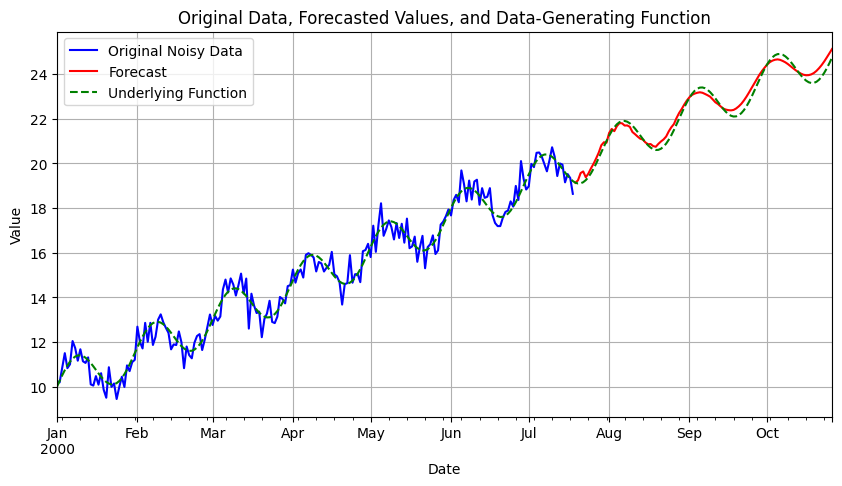

In [1453]:
model = ARIMA(p=25, i=1, q=1, df=df)
preds = forecast(model, steps=100)

# Get the last timestamp from the original series
last_date = df.index[-1]

# Create a datetime index for the forecast period
future_dates = pd.date_range(start=last_date + pd.Timedelta('1D'), periods=len(preds), freq='D')

# Convert the predictions to a pandas Series
pred_series = pd.Series(preds, index=future_dates, name='Forecast')

print(pred_series)

# ---------------------------------------------------------
# Plot the underlying function (the deterministic part without noise)
# We know the original generation parameters (from previous context).
# Recreate them for the entire period + forecast:

original_length = len(df)
forecast_length = len(preds)
extended_length = original_length + forecast_length

extended_index = pd.date_range(start=df.index[0], periods=extended_length, freq='D')

underlying_seasonal = np.sin(2 * np.pi * np.arange(extended_length) / seasonality_period)
trend = 0.05 * np.arange(extended_length)
underlying_pattern = offset + trend + underlying_seasonal

underlying_series = pd.Series(underlying_pattern, index=extended_index, name='Underlying Function')

# ---------------------------------------------------------
# Plot all three: original data, forecast, and underlying function

fig, ax = plt.subplots(figsize=(10, 5))
df.plot(ax=ax, label='Original Noisy Data', color='blue')
pred_series.plot(ax=ax, label='Forecast', color='red')
underlying_series.plot(ax=ax, label='Underlying Function', color='green', linestyle='--')

plt.title("Original Data, Forecasted Values, and Data-Generating Function")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()


In [1454]:
# read daily close price data
file_path = '/Users/edocampione/Desktop/Meng Engineering Science/4YP/data/ExxonMobil_CRSP_daily_data_alltime.csv'
df = pd.read_csv(file_path)

# Ensure that the date column is in datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Keep both the 'date' and 'PRC' columns
df = df[["date", "PRC"]].copy()

print(df.head())

        date    PRC
0 1925-12-31  46.00
1 1926-01-02  46.00
2 1926-01-04  45.50
3 1926-01-05  45.25
4 1926-01-06  45.00


In [1455]:
# Set 'date' as the index
df.set_index('date', inplace=True)

# Resample and keep only the last available price of each week
f = 'W-SUN' # 'W-SUN' means week ending on Sunday
df = df.resample(f).last()  

# Reset index if you want 'date' as a column again
#df.reset_index(inplace=True)

# Show the first few rows of the resulting DataFrame
print(df.head())


               PRC
date              
1926-01-03  46.000
1926-01-10  45.250
1926-01-17  43.875
1926-01-24  43.625
1926-01-31  45.250


In [1456]:
# check for missing values
print("Missing values:", df.isnull().sum())
# remove missing values
df = df.dropna()

print(df.head())

Missing values: PRC    1
dtype: int64
               PRC
date              
1926-01-03  46.000
1926-01-10  45.250
1926-01-17  43.875
1926-01-24  43.625
1926-01-31  45.250


In [1457]:
# Display summary statistics
df['PRC'].describe()

count    5113.000000
mean       64.109692
std        20.174228
min        20.500000
25%        47.875000
50%        63.375000
75%        78.100000
max       168.500000
Name: PRC, dtype: float64

In [1458]:
start_date = '2017-1-30'
end_train_date = '2018-9-30'

# Filter the data according to the date range
train_data = df[(df.index >= start_date) & (df.index <= end_train_date)]
test_data = df[(df.index >= train_data.index[-1])]

In [1459]:
def AR(p,df):
  df_temp = df

  #Generating the lagged p terms
  for i in range(1,p+1):
    df_temp['Shifted_values_%d' % i ] = df_temp['PRC'].shift(i)
  
  df_temp = df_temp.dropna()

  #X contains the lagged values ,hence we skip the first column
  X_train = df_temp.iloc[:,1:].values.reshape(-1,p)
  #Y contains the value,it is the first column
  y_train = df_temp.iloc[:,0].values.reshape(-1,1)

  #Running linear regression to generate the coefficents of lagged terms
  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  df_temp['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  df_temp = df_temp.dropna()
  
  return [df_temp,theta,intercept]

In [1460]:
def MA(q,res):

  for i in range(1,q+1):
    res['Shifted_values_%d' % i ] = res['Residuals'].shift(i)

  res = res.dropna()
  X_train = res.iloc[:,1:].values.reshape(-1,q)
  y_train = res.iloc[:,0].values.reshape(-1,1)

  from sklearn.linear_model import LinearRegression
  lr = LinearRegression()
  lr.fit(X_train,y_train)

  theta  = lr.coef_.T
  intercept = lr.intercept_
  res['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
  # res_train_2[['Residuals','Predicted_Values']].plot()


  return [res,theta,intercept]


In [1461]:
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','Number of Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary \n")

In [1462]:
df_testing = pd.DataFrame(np.log(train_data.PRC).diff())
adf_check(df_testing.PRC.dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -4.534939546236297
p-value : 0.0001699478671159169
Number of Lags Used : 9
Number of Observations Used : 76
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [1463]:
[df_c,theta,intercept] = AR(3,pd.DataFrame(df_testing.PRC))
print(theta)

[[ 0.07145536]
 [-0.2230917 ]
 [ 0.1992374 ]]


<Axes: xlabel='date'>

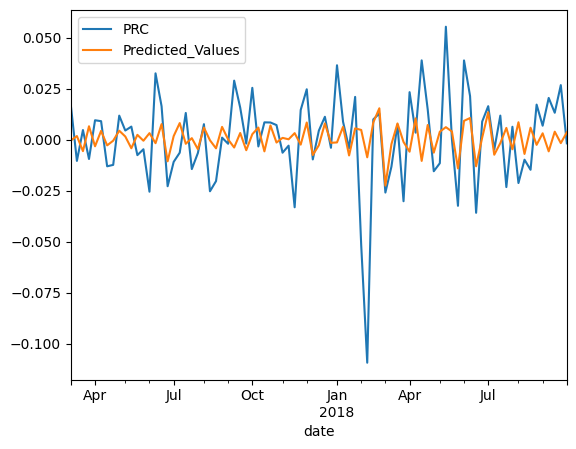

In [1464]:

df_c[['PRC','Predicted_Values']].plot()

<Axes: ylabel='Density'>

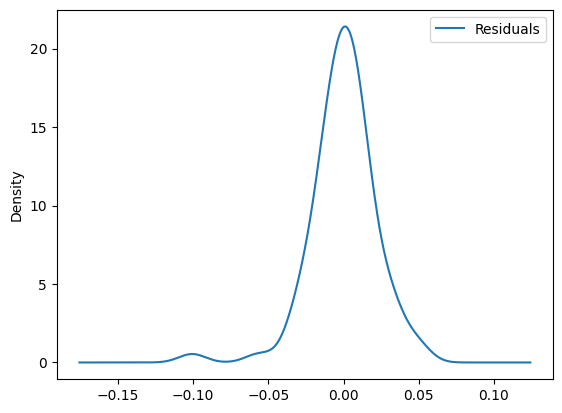

In [1465]:
res = pd.DataFrame()
res['Residuals'] = df_c.PRC - df_c.Predicted_Values
res.plot(kind='kde')

In [1466]:
[res_c,theta,intercept] = MA(3,pd.DataFrame(res.Residuals))

In [1467]:
df_c.PRC += np.log(df).shift(1).PRC
df_c.Predicted_Values += np.log(df).shift(1).PRC 
df_c.PRC = np.exp(df_c.PRC)
df_c.Predicted_Values = np.exp(df_c.Predicted_Values)

print(df_c)

              PRC  Shifted_values_1  Shifted_values_2  Shifted_values_3  \
date                                                                      
2017-03-05  82.46         -0.008352         -0.009253         -0.012285   
2017-03-12  81.61          0.016877         -0.008352         -0.009253   
2017-03-19  82.00         -0.010362          0.016877         -0.008352   
2017-03-26  81.23          0.004767         -0.010362          0.016877   
2017-04-02  82.01         -0.009435          0.004767         -0.010362   
...           ...               ...               ...               ...   
2018-09-02  80.17          0.017229         -0.014714         -0.009773   
2018-09-09  81.83          0.006884          0.017229         -0.014714   
2018-09-16  82.92          0.020495          0.006884          0.017229   
2018-09-23  85.17          0.013232          0.020495          0.006884   
2018-09-30  85.02          0.026773          0.013232          0.020495   

            Predicted_Va

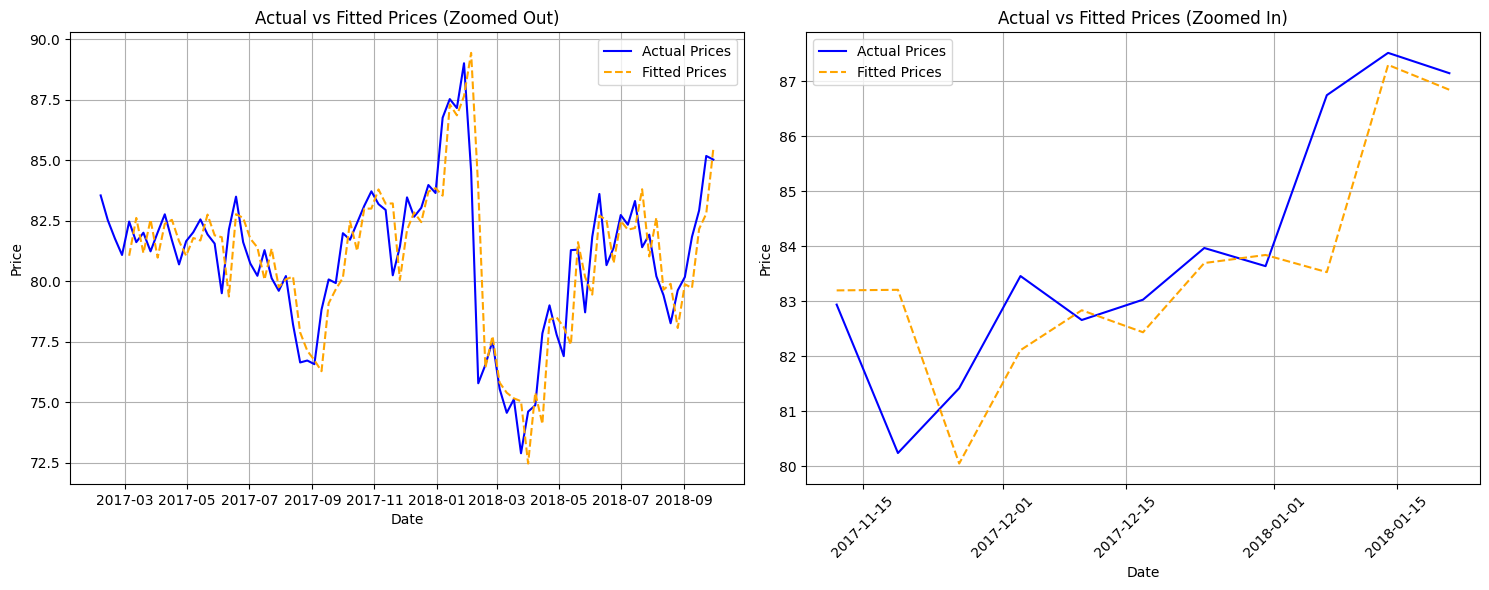

In [1468]:
# Get the fitted values
fitted_values = df_c.Predicted_Values

# Define the range of dates for the zoomed-in plot
start_date = train_data.index[40]  # Adjust this index to the start of your desired section
end_date = train_data.index[50]   # Adjust this index to the end of your desired section

# Create a figure with 2 subplots (zoomed-out and zoomed-in)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the zoomed-out actual vs fitted prices (full range)
axes[0].plot(train_data.index, train_data['PRC'], label='Actual Prices', color='blue')
axes[0].plot(fitted_values.index, fitted_values, label='Fitted Prices', color='orange', linestyle='--')
axes[0].set_title('Actual vs Fitted Prices (Zoomed Out)')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True)

# Plot the zoomed-in actual vs fitted prices (subset of data)
axes[1].plot(train_data.loc[start_date:end_date].index, train_data.loc[start_date:end_date, 'PRC'], label='Actual Prices', color='blue')
axes[1].plot(train_data.loc[start_date:end_date].index, fitted_values.loc[start_date:end_date], label='Fitted Prices', color='orange', linestyle='--')
axes[1].set_title('Actual vs Fitted Prices (Zoomed In)')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Price')
axes[1].legend()
axes[1].grid(True)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plot
plt.show()


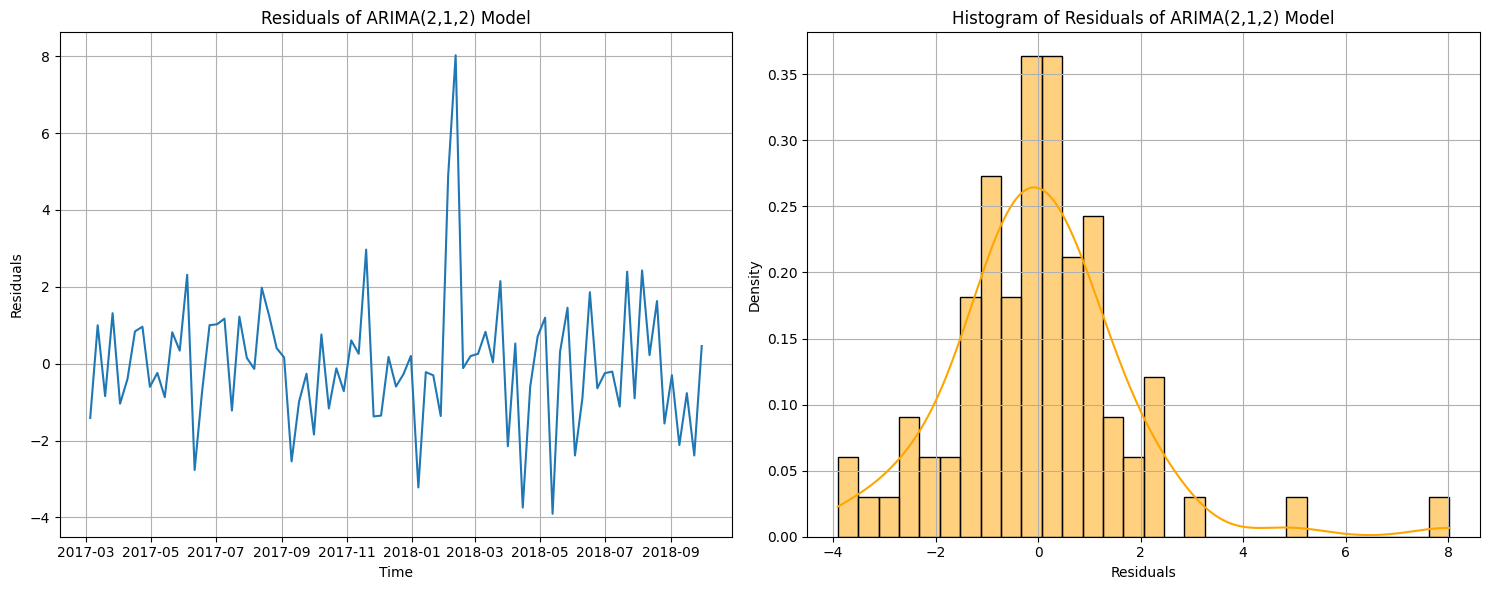

In [1469]:
# Get the residuals (difference between observed and fitted values)
residuals = df_c.Predicted_Values - train_data['PRC']

# Create a figure with 2 subplots (one for residuals and one for histogram)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the residuals
axes[0].plot(residuals)
axes[0].set_title('Residuals of ARIMA(2,1,2) Model')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Residuals')
axes[0].grid(True)

# Plot the histogram of residuals
sns.histplot(residuals, kde=True, bins=30, color='orange', stat='density', ax=axes[1])  # KDE = Kernel Density Estimation
axes[1].set_title('Histogram of Residuals of ARIMA(2,1,2) Model')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Density')
axes[1].grid(True)

# Adjust layout to avoid overlapping labels
plt.tight_layout()

# Show the plots
plt.show()

In [1470]:
# Forecast the next 60 steps beyond the training data (e.g., 60 future periods)
forecast_steps = 20
forecast_results = model_fit.get_forecast(steps=forecast_steps)

# Forecasted values
forecast_values = forecast_results.predicted_mean

plt.figure(figsize=(10, 6))

# Plot the forecasted values (future predictions beyond the training period)
forecast_index = pd.date_range(train_data.index[-1], periods=forecast_steps + 1, freq=f)[1:]  # Generate future dates


plt.plot(forecast_index, forecast_values, label='Forecasted Prices', color='green', linestyle='--')


NameError: name 'model_fit' is not defined

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Forecast the next 30 steps beyond the training data (e.g., 30 future periods)
forecast_steps = 100
forecast_results = model_fit.get_forecast(steps=forecast_steps)

# Forecasted values
forecast_values = forecast_results.predicted_mean

# Generate future dates for the forecasted values
forecast_index = pd.date_range(train_data.index[-1], periods=forecast_steps + 1, freq=f)[1:]

# Slice the test data to only the first 30 days
test_data_30 = test_data['PRC'].iloc[:forecast_steps] 

# Plotting the forecasted values and actual data
plt.figure(figsize=(10, 6))

# Plot the forecasted values (future predictions beyond the training period)
plt.plot(forecast_index, forecast_values[:forecast_steps], label='Forecasted Prices', color='green', linestyle='--')

# Plot the actual test data (first 30 days)
plt.plot(test_data_30.index, test_data_30, label='Actual Test Prices', color='red')

# Customize the plot
plt.title('Forecasted vs Actual Test Prices (First 30 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


NameError: name 'model_fit' is not defined

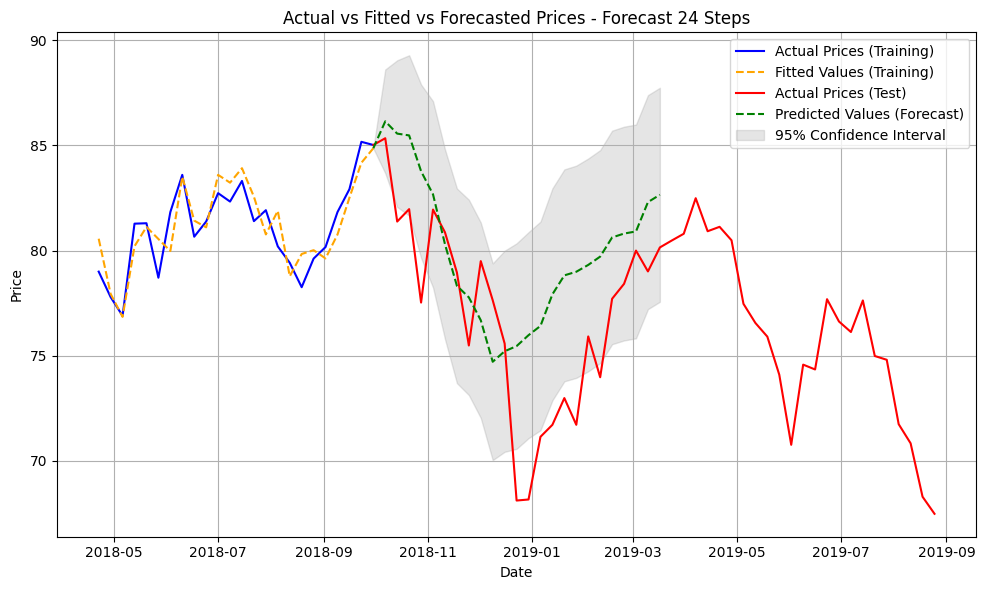

In [ ]:
# Define the number of steps you want to forecast
forecast_steps = 24 # You can change this value to whatever number of steps you want

# Forecast the next 'forecast_steps' values (out-of-sample prediction)
forecast_results = model_fit.get_forecast(steps=forecast_steps)

# Forecasted values
forecast_values = forecast_results.predicted_mean

# Append the last fitted value to the front of the forecasted values
x = model_fit.fittedvalues.iloc[-1]
forecast_values = pd.concat([pd.Series(x), forecast_values], ignore_index=True)

# Confidence intervals for the forecast
conf_int = forecast_results.conf_int(alpha=0.05)
init_row = pd.DataFrame([[x, x]], columns=conf_int.columns)  # Initialise both bounds
conf_int = pd.concat([init_row, conf_int], ignore_index=True)

# Filter the data for the post-2018 period
train_data_filtered = train_data.iloc[-24:]


# Create the plot (only the right side for post-2018)
fig, ax = plt.subplots(figsize=(10, 6))

# Plot actual vs fitted vs forecasted values for the post-2018 period
ax.plot(train_data_filtered.index, train_data_filtered['PRC'], label='Actual Prices (Training)', color='blue')
ax.plot(train_data_filtered.index, model_fit.fittedvalues.loc[train_data_filtered.index], label='Fitted Values (Training)', color='orange', linestyle='--')
ax.plot(test_data.index[:(forecast_steps*2)], test_data['PRC'][:(forecast_steps*2)], label='Actual Prices (Test)', color='red')
ax.plot(test_data.index[:forecast_steps+1], forecast_values, label='Predicted Values (Forecast)', color='green', linestyle='--')
ax.fill_between(test_data.index[0:forecast_steps+1], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='95% Confidence Interval')

# Customize the plot
ax.set_title(f'Actual vs Fitted vs Forecasted Prices - Forecast {forecast_steps} Steps')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True)

# Display the plot
plt.tight_layout()
plt.show()

